IMPORTS

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

FUNCTION

In [22]:
# Function to load and preprocess the data, ensuring balanced quality labels
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df = df.drop(columns=['A_id'])

    # Balance the dataset by undersampling
    quality_good = df[df['Quality'] == 'good']
    quality_bad = df[df['Quality'] == 'bad']
    
    min_count = min(len(quality_good), len(quality_bad))
    
    quality_good = quality_good.sample(min_count, random_state=42)
    quality_bad = quality_bad.sample(min_count, random_state=42)
    
    balanced_df = pd.concat([quality_good, quality_bad]).reset_index(drop=True)

    # Convert categorical columns to numeric using one-hot encoding
    balanced_df = pd.get_dummies(balanced_df)
    
    return balanced_df

# Function to standardize the features
def standardize_features(df):
    features = df.drop(columns=['Quality_bad', 'Quality_good'])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features.values)
    return scaled_features, features.columns

# Function to plot the elbow graph to determine the optimal number of clusters
def plot_elbow(X):
    inertia = []
    K = range(1, 20)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

# Function to apply K-means clustering and add cluster labels to the dataframe
def apply_kmeans(X, df, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    return kmeans

# Function to visualize the clusters using PCA
def plot_clusters(X, df):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('K-means Clustering Visualization')
    plt.colorbar(label='Cluster')
    plt.show()

# Function to calculate and plot the silhouette scores
def plot_silhouette(X, df, n_clusters):
    silhouette_avg = silhouette_score(X, df['Cluster'])
    print(f'The silhouette score for the clustering is: {silhouette_avg:.4f}')
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    sample_silhouette_values = silhouette_samples(X, df['Cluster'])
    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[df['Cluster'] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
    plt.show()

USAGE

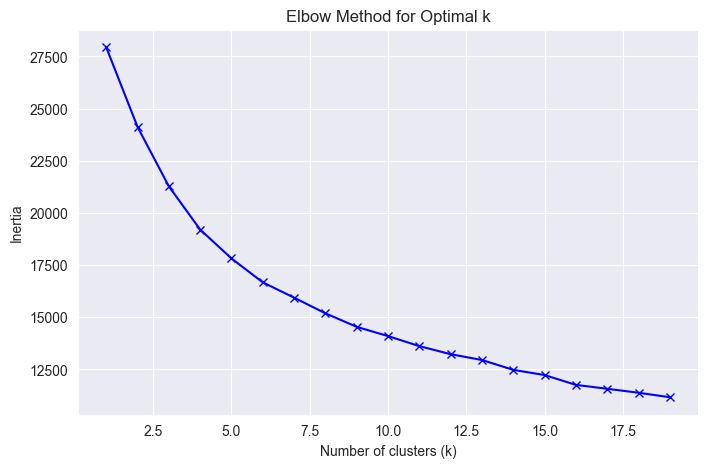

       Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -2.123387 -1.689085   2.824588    -1.330053   0.955951  0.772548 -4.125685   
1  0.715230  2.700857  -2.780518    -1.566420   1.023802  0.191156  0.186521   
2 -1.697410  0.034973   0.273230     1.132297   2.695980 -0.242546 -3.365377   
3  4.136380 -2.058474  -0.124516    -2.001654   4.248300  0.850352  4.393659   
4 -1.318453  1.167760  -2.021884     3.139990  -0.589076 -2.563033 -1.927134   

   Quality_bad  Quality_good  Cluster  
0        False          True        1  
1        False          True        1  
2        False          True        1  
3        False          True        0  
4        False          True        1  


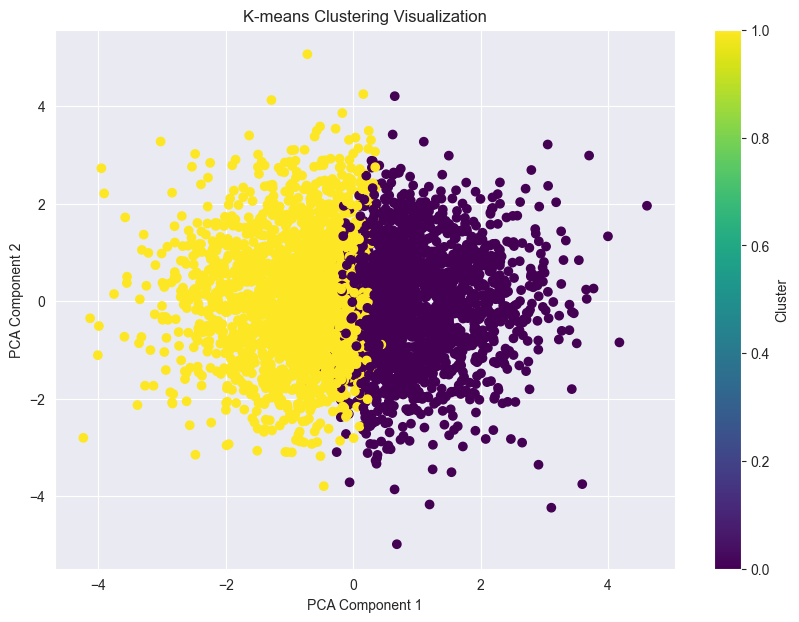

The silhouette score for the clustering is: 0.1330


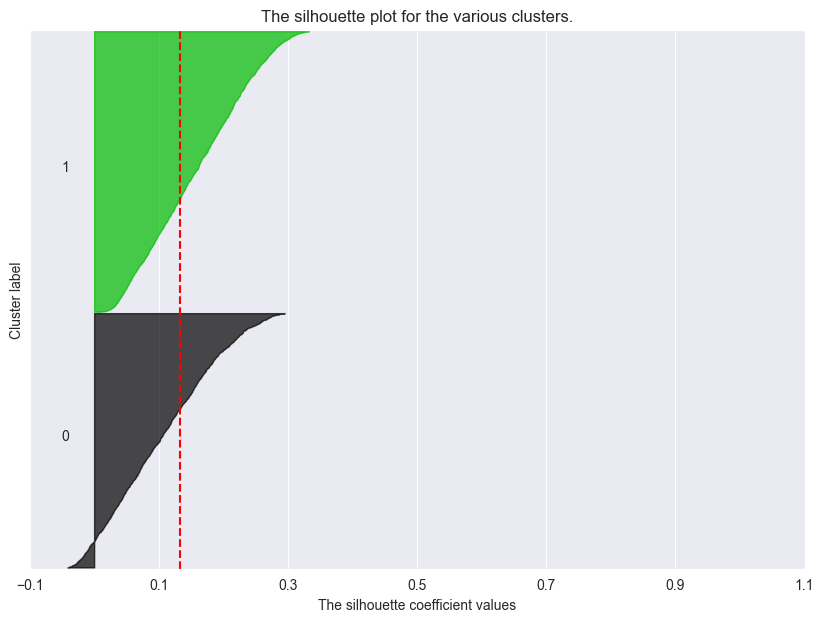

             Size   Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
Cluster                                                                   
0       -0.085167 -1.20543   0.207708     1.285187   1.252014 -0.482340   
1       -0.884389 -0.78888  -1.090062     0.714355  -0.160662  1.386915   

          Acidity  Quality_bad  Quality_good  
Cluster                                       
0        1.410674     0.375659      0.624341  
1       -1.133763     0.612703      0.387297  


In [24]:
apples_df = load_and_preprocess_data("apple_quality.csv")
AX_scaled, feature_columns = standardize_features(apples_df)

# Plot the elbow graph to determine the optimal number of clusters
plot_elbow(X_scaled)

# Set the optimal number of clusters (e.g., determined from the elbow plot)
k_optimal = 2  # Adjust this based on the elbow plot

# Apply K-means clustering
kmeans = apply_kmeans(X_scaled, apples_df, k_optimal)

# Show the first few rows of the dataframe with the cluster labels
print(apples_df.head())

# Visualize the clusters using PCA
plot_clusters(X_scaled, apples_df)

# Calculate and plot the silhouette scores
plot_silhouette(X_scaled, apples_df, k_optimal)

# Group the original data by the cluster labels and calculate mean values for each cluster
cluster_summary = apples_df.groupby('Cluster').mean()
print(cluster_summary)